Импортируем все необходимые библиотеки и скачиваем модель

In [1]:
import collections

In [2]:
import sys
import gensim, logging
import scipy
import scipy.cluster.hierarchy as hcluster
import matplotlib.pyplot as plt

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors

import numpy as np

In [4]:
import zipfile
import wget

model_url = 'http://vectors.nlpl.eu/repository/20/180.zip'
m = wget.download(model_url)
model_file = model_url.split('/')[-1]
with zipfile.ZipFile(model_file, 'r') as archive:
    stream = archive.open('model.bin')
    model = gensim.models.KeyedVectors.load_word2vec_format(stream, binary=True)

 99% [..................................................................... ] 483246080 / 484452317

2022-02-12 15:31:19,208 : INFO : loading projection weights from <zipfile.ZipExtFile name='model.bin' mode='r' compress_type=deflate>


100% [......................................................................] 484452317 / 484452317

2022-02-12 15:31:26,146 : INFO : KeyedVectors lifecycle event {'msg': 'loaded (189193, 300) matrix of type float32 from <zipfile.ZipExtFile [closed]>', 'binary': True, 'encoding': 'utf8', 'datetime': '2022-02-12T15:31:26.146409', 'gensim': '4.1.2', 'python': '3.10.0 (tags/v3.10.0:b494f59, Oct  4 2021, 19:00:18) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'load_word2vec_format'}


In [5]:
model.save("word2vec.model") 

2022-02-12 15:31:26,159 : INFO : KeyedVectors lifecycle event {'fname_or_handle': 'word2vec.model', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2022-02-12T15:31:26.159840', 'gensim': '4.1.2', 'python': '3.10.0 (tags/v3.10.0:b494f59, Oct  4 2021, 19:00:18) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'saving'}
2022-02-12 15:31:26,162 : INFO : storing np array 'vectors' to word2vec.model.vectors.npy
2022-02-12 15:31:26,869 : INFO : saved word2vec.model


Достаем все существительные, чтобы потом их векторизовать.

In [6]:
verb = 'играть_VERB'
nouns = []
with open("HW2_igrat'.txt", 'r', encoding='utf-8') as file:
    f = file.readlines()
    for line in f:
        add = line.split('\t')
        nouns.append(str(add[0].split('_')[1]) + '_NOUN')

Заводим переменную для вектора глагола и матрицу, в которой буду храниться все значения словосочетаний. 

In [7]:
verb_vector = np.array(model['играть_VERB'])
add_matrix = []

In [8]:
d = {}
for n in nouns:
    if n in model:
        add_matrix.append(verb_vector + np.array(model[n]))

In [9]:
add_matrix = np.array(add_matrix)

#### Иерархическая кластеризация
Поигравшись с параметрами, находим такие, при которых у нас есть 16 кластеров (так при методе simple количество кластеров было либо 1, либо 71). 

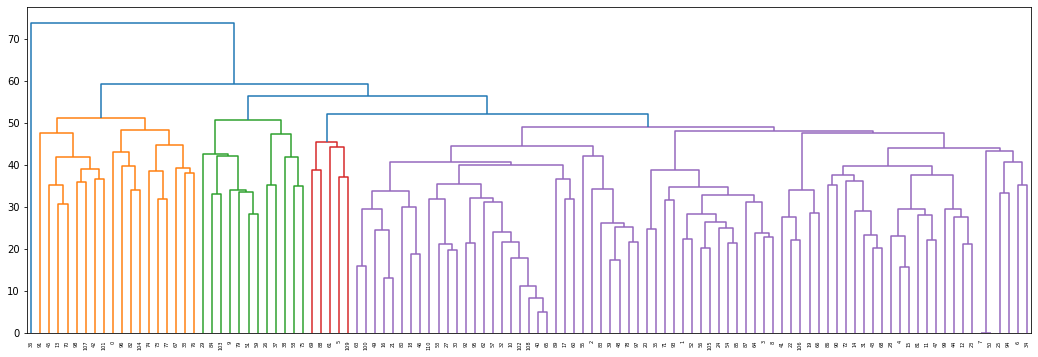

In [10]:
Z = hcluster.linkage(add_matrix, method='complete', metric='euclidean')
plt.figure(figsize=(18, 6))
dn = hcluster.dendrogram(Z)
plt.show()

In [11]:
clusters = hcluster.fclusterdata(Z, 1.15)
print('Estimated number of clusters: %d' % len(set(clusters)))

Estimated number of clusters: 16


In [12]:
clusters

array([12, 10,  4,  4,  6,  6, 10, 10, 10,  7,  7, 10, 10,  6, 10, 10, 10,
       10, 10, 10,  7,  7,  6, 10, 10, 10, 10, 10,  7, 10, 10, 10, 10, 10,
       10, 10, 10, 10,  5, 10, 10, 10, 10, 10,  5, 10, 10, 10, 10,  5, 10,
       10, 10, 10, 10, 10, 10, 10, 13, 10, 10, 10, 10, 10,  8,  3,  7, 10,
       10, 10, 10, 10, 11, 10, 10,  9, 10, 10, 10, 10,  3, 10, 10, 10, 10,
       10, 10,  3, 10,  3, 14, 15,  2, 10,  3, 10, 10, 10, 10,  2, 10, 10,
       10,  1, 10, 10,  1,  1,  1, 16], dtype=int32)

Посмотрим, в каких кластерах больше двух словосочетаний.

In [13]:
collections.Counter(clusters).most_common(6)
#10, 7, 3, 6, 1, 5

[(10, 76), (7, 6), (3, 5), (6, 4), (1, 4), (5, 3)]

Соберём индексы всех словосочетаний, чтобы потом искать среднее

In [14]:
c = 0
c10 = []
c1 = []
c3 = []
c5 = []
c6 = []
c7 = []
for cluster in clusters:
    if cluster == 10:
        c10.append(c)
    elif cluster == 1:
        c1.append(c)
    elif cluster == 3:
        c3.append(c)
    elif cluster == 5:
        c5.append(c)
    elif cluster == 6:
        c6.append(c)
    elif cluster == 7:
        c7.append(c)
    c += 1

дальше в функции я пользуюсь тем, что индекс вектора слова в матрице и индекс слова в списке существительных одинаковый

In [26]:
def get_center(index_list):
    m = {}
    centroids = []
    cl_matrix = []
    for ind in index_list:
        cl_matrix.append(add_matrix[ind])
    center = np.mean(cl_matrix, axis = 0)
    for i in index_list:
        m[ds.cosine(center, add_matrix[i])] = nouns[i]
    closest = sorted(m.keys())[0:3]
    for d in closest:
        centroids.append('играть_'+ str(m[d].split('_')[0]))
    return center, centroids

In [29]:
center10, centroids10 = get_center(c10)
center1, centroids1 = get_center(c1)
center3, centroids3 = get_center(c3)
center5, centroids5 = get_center(c5)
center6, centroids6 = get_center(c6)
center7, centroids7 = get_center(c7)

Получаем центры кластеров, результаты обсудим ниже.
Пока сделаем то же для к-средних

In [33]:
print(centroids1)
print(centroids3)
print(centroids5)
print(centroids6)
print(centroids7)
print(centroids10)

['играть_утро', 'играть_процесс', 'играть_дело']
['играть_трубач', 'играть_звезда', 'играть_шарманка']
['играть_девушка', 'играть_сцена', 'играть_рука']
['играть_актер', 'играть_человек', 'играть_жизнь']
['играть_дитя', 'играть_девочка', 'играть_актриса']
['играть_россия', 'играть_старуха', 'играть_игра']


Про количество кластеров: при числе 7 в каждый кластер входит 4+ слов, так что оставим так (при 8 кластерах уже есть кластеры в 2 слова)

In [43]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=7).fit(add_matrix)
kmeans.labels_

array([4, 6, 5, 6, 0, 5, 6, 6, 6, 1, 5, 0, 0, 5, 6, 0, 2, 6, 2, 3, 6, 2,
       3, 0, 6, 6, 1, 2, 0, 1, 2, 6, 5, 4, 3, 5, 3, 1, 2, 5, 6, 3, 5, 6,
       0, 5, 2, 0, 5, 2, 6, 1, 6, 2, 6, 5, 6, 6, 2, 1, 6, 5, 2, 2, 6, 6,
       3, 6, 6, 5, 5, 6, 6, 4, 4, 1, 5, 4, 5, 1, 2, 0, 4, 5, 1, 6, 6, 6,
       5, 3, 6, 6, 6, 6, 6, 2, 4, 5, 5, 0, 2, 5, 6, 1, 4, 6, 3, 5, 6, 2,
       2])

In [44]:
collections.Counter(kmeans.labels_)
#0-6

[(6, 36), (5, 22), (2, 17), (0, 10), (1, 10), (4, 8), (3, 8)]

In [45]:
c = 0
k0 = []
k1 = []
k2 = []
k3 = []
k4 = []
k5 = []
k6 = []
for cluster in kmeans.labels_:
    if cluster == 0:
        k0.append(c)
    elif cluster == 1:
        k1.append(c)
    elif cluster == 2:
        k2.append(c)
    elif cluster == 3:
        k3.append(c)
    elif cluster == 4:
        k4.append(c)
    elif cluster == 5:
        k5.append(c)
    elif cluster == 6:
        k6.append(c)
    c += 1

In [46]:
k_center0, k_centroids0 = get_center(k0)
k_center1, k_centroids1 = get_center(k1)
k_center3, k_centroids3 = get_center(k3)
k_center5, k_centroids5 = get_center(k5)
k_center6, k_centroids6 = get_center(k6)
k_center2, k_centroids2 = get_center(k2)
k_center4, k_centroids4 = get_center(k4)

In [48]:
print(k_centroids0)
print(k_centroids1)
print(k_centroids2)
print(k_centroids3)
print(k_centroids4)
print(k_centroids5)
print(k_centroids6)

['играть_актер', 'играть_спектакль', 'играть_артист']
['играть_солнце', 'играть_лицо', 'играть_свет']
['играть_мальчик', 'играть_девочка', 'играть_мальчишка']
['играть_вечер', 'играть_день', 'играть_моцарт']
['играть_молчанка', 'играть_труппа', 'играть_матч']
['играть_дитя', 'играть_гамлет', 'играть_отец']
['играть_трубач', 'играть_россия', 'играть_старуха']


#### Перёдем к анализу результатов
Сначала посмотрим на результат иерхарической кластеризации. Честно говоря, я не очень довольна результатами: например, если *девочка* и *дитя* довольно схожи, причем они как раз могут использоваться в одних контекстах (девочка/дитя играет с игрушкой на полу), то *актриса* сюда особо не походит, хотя подошла бы к *актеру* из соседнего кластера.
Результаты в k-means мне нравятся больше. Тут уже вместе идут слова *актер* и *артист* (где *актриса* мы не знаем, но, возможно, там же), *солнце* и *свет* - слова которые скорее не встанут в одну позицию в предложении, но при этом имеют схожую семантику света. С другой стороны, тут тоже есть проблемы: например, *Россия* и *трубач*, кажется, не очень соединяются